## GENERATING IMAGES WITH VARIATIONAL AUTOENCODERS
![title](./pics/auto-encoder-intro.png) 

##  conventional autoencoders
![title](./pics/auto-encoder.png) 

##  variational auto encoders (VAE)
![title](./pics/VAE.png) 

{  z = z_mean + exp(z_log_variance) * epsilon   }  + decoder = generated image

```
VAE are trained via two loss functions: 
- a reconstruction loss that forces the decoded samples to match the initial input 
- regularization loss, which helps in learning well-formed latent spaces and reducing overfitting to the training data
```

### Schematic formulation of a Variational Autoencoder (VAE)

Encode the input into a mean and variance parameter
#### z_mean, z_log_variance = encoder(input_img)
Draw a latent point using a small random epsilon
#### z = z_mean + exp(z_log_variance) * epsilon
Then decode z back to an image
#### reconstructed_img = decoder(z)
Instantiate a model
#### model = Model(input_img, reconstructed_img)
Then train the model using 2 losses:a reconstruction loss and a regularization loss

In [6]:
#imports

#keras imports
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
from keras import layers
import keras


#general imports
import numpy as np
from scipy.stats import norm

# visualiaztion imports
%matplotlib inline
import matplotlib.pyplot as plt

## THE VAE ENCODER NETWORK

In [2]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

## The VAE decoder network

In [3]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.
# This is our decoder model.
decoder = Model(decoder_input, x)
decoder.summary()

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


### A custom layer used to compute the VAE loss

In [4]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return z_decoded
    
# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

### Training the VAE

In [5]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()
# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

### Sampling a grid of points from the 2D latent space and decoding them to images

we will use the decoder network to turn arbitrary latent space vectors into images

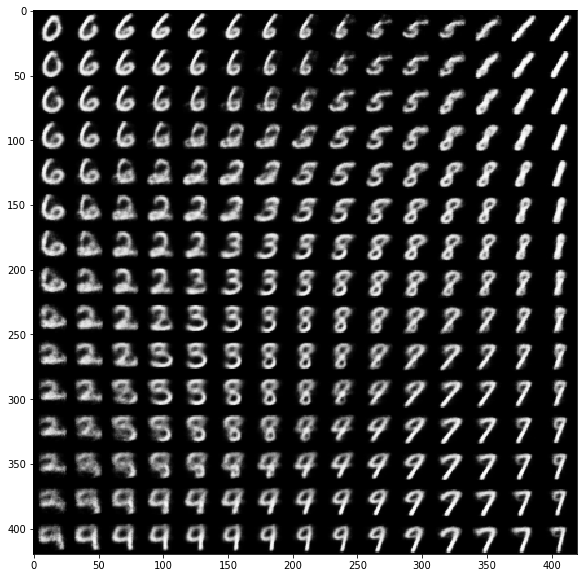

In [7]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### There are two major tools to generate image with deep learning: VAEs and GANs.
- VAEs result in highly structured, continuous latent representations. For this reason, they work well for doing all sort of image edition in latent space, like face swapping, turning a frowning face into a smiling face, and so on. They also work nicely for doing latent space based animations, i.e. animating a walk along a cross section of the latent space, showing a starting image slowly morphing into different images in a continuous way.
- GANs enable the generation of realistic single-frame images, but may not induce latent spaces with solid structure and high continuity.

Note: To play further with image generation, I suggest working with the CelebA dataset, "Large-scale Celeb Faces Attributes"